In [1]:
from integsol.mesh.mesh import Mesh
from integsol.compute.vectors import VectorField
from integsol.compute.operators import (
    IntegralConvolutionOperator as ICO,
    CrossProductOperator as CPO,
)
from integsol.validators.compute_validators import *
from integsol.compute.kernels import demagnetization_tensor_kernel as dtk
import numpy as np
from torch.linalg import eig
from torch import (
    Tensor,
    dot,
    matmul,
    mv,
)


In [2]:
M_s = 1.45 * 1e4
gamms = 2.25 * 1e4

In [3]:
mesh = Mesh.read(path="/home/aluatar/integsol/test_inputs/mesh_coerser.mphtxt")
#mesh_2 = Mesh.read(path="/home/aluatar/integsol/test_inputs/mesh_coerser.mphtxt")

Begin calculation of elements measures.
Calculate measures for vtx type of elements
Calculate measures for edg type of elements
Progress: 98.21%

Calculate measures for tri type of elements
Progress: 99.75%

Calculate measures for tet type of elements
Progress: 99.95%

Calculation of measures of all elements finished in 8.031173944473267 seconds.


In [4]:
centers = mesh.elements_centers['tet'].T
nodes = mesh.coordinates.T
elements = mesh.elements_coordinates
elements

{'vtx': array([[[-4.5924255e-14, -2.5000000e+02, -2.5000000e+02]],
 
        [[-2.5000000e+02,  3.0616170e-14, -2.5000000e+02]],
 
        [[ 2.5000000e+02,  0.0000000e+00, -2.5000000e+02]],
 
        [[-4.5924255e-14, -2.5000000e+02,  2.5000000e+02]],
 
        [[ 1.5308085e-14,  2.5000000e+02, -2.5000000e+02]],
 
        [[-2.5000000e+02,  3.0616170e-14,  2.5000000e+02]],
 
        [[ 2.5000000e+02,  0.0000000e+00,  2.5000000e+02]],
 
        [[ 1.5308085e-14,  2.5000000e+02,  2.5000000e+02]]]),
 'edg': array([[[-2.30969517e+02, -9.56707064e+01, -2.50000000e+02],
         [-1.76776695e+02, -1.76776695e+02, -2.50000000e+02]],
 
        [[-1.76776695e+02, -1.76776695e+02, -2.50000000e+02],
         [-9.56707064e+01, -2.30969517e+02, -2.50000000e+02]],
 
        [[-9.56707064e+01, -2.30969517e+02, -2.50000000e+02],
         [-4.59242550e-14, -2.50000000e+02, -2.50000000e+02]],
 
        [[-4.59242550e-14, -2.50000000e+02, -2.50000000e+02],
         [ 9.56707064e+01, -2.30969517e+02, -2.

In [5]:
A = np.array(
    [
        [[1,2,3],
        [4,5,6]],
        [[7,8,9],
         [10,11,12]]
    ]
)
np.sum(A, axis=0)
np.nan + 2

nan

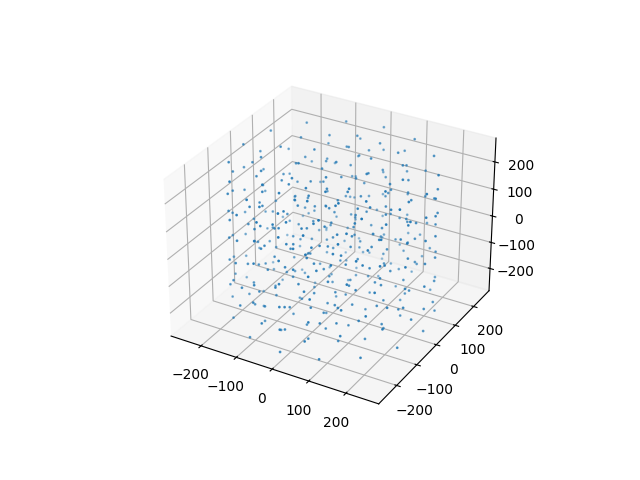

In [6]:
%matplotlib widget
import matplotlib.pyplot as plt 
import numpy as np

fig = plt.figure()

ax = fig.add_subplot(projection='3d')

ax.scatter(xs=np.float64(nodes[0]), ys=np.float64(nodes[1]), zs=np.float64(nodes[2]), s=1)
#ax.scatter(xs=mesh.coordinates[Hd_nodes_nans][0], ys=mesh.coordinates[Hd_nodes_nans][1], zs=mesh.coordinates[Hd_nodes_nans][2], color='red')

In [7]:
coord_to_write = []
X, Y, Z =[], [], []
for coordinate in centers.T:
    X.append(coordinate[0])
    Y.append(coordinate[1])
    Z.append(coordinate[2])

coord_to_write = zip(X,Y,Z)

from datetime import datetime
import csv

with open(F"/home/aluatar/integsol/outputs/interpolation_coordinates/coordinates_{datetime.now()}.txt", 'w') as _csv:
    writer = csv.writer(_csv, delimiter='\t')
    writer.writerows(coord_to_write)

In [7]:
M0 = VectorField.read_to_mesh(
    path="/home/aluatar/integsol/test_inputs/magnetization_coerser.txt",
    mesh=mesh,
    dim=3)


_M0 = M0.vectorize()

In [8]:
M0_cpo = CPO(
    mesh=mesh,
    left_vector= M0
)

M0_times_ = M0_cpo.to_mesh_matrix()
M0_times_

Begin placement of operator on mesh elements' centers.
Progress: 0.1%%

Progress: 99.95%

Mesh matric of the operator generated in 2.754352331161499 seconds.


tensor([[ 0.0000e+00, -1.0000e+00,  9.5869e-05,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.0000e+00,  0.0000e+00, -1.3177e-04,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-9.5869e-05,  1.3177e-04,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -0.0000e+00,
         -1.0000e+00, -4.7344e-05],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
         -0.0000e+00,  6.2193e-05],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  4.7344e-05,
         -6.2193e-05,  0.0000e+00]])

In [9]:
ico = ICO(kernel=dtk)
int_G_ = ico.to_mesh_matrix(mesh=mesh)

Begin placement of operator on mesh elements' centers.
Progress: 99.95%

Mesh matric of the operator generated in 330.3667588233948 seconds.


In [12]:
H_eff = VectorField.read_to_mesh(
    path="/home/aluatar/integsol/test_inputs/H_demag.txt",
    mesh=mesh,
    dim=3)

_H_eff = H_eff.vectorize()
vals_H_eff = H_eff.values.T

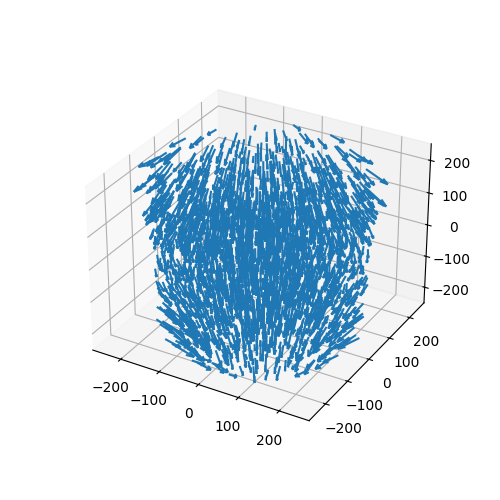

In [13]:
%matplotlib inline
%matplotlib widget 

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot(projection="3d") 

ax.quiver(
    centers[0],
    centers[1],
    centers[2],
    vals_H_eff[0],
    vals_H_eff[1],
    vals_H_eff[2],
    length=0.001,
)

plt.show()

In [17]:
H_eff_cpo = CPO(
    mesh=mesh,
    left_vector=H_eff
)
H_eff_times_ = H_eff_cpo.to_mesh_matrix()

Begin placement of operator on mesh elements' centers.
Progress: 1.2%%

Progress: 99.95%

Mesh matric of the operator generated in 2.7178361415863037 seconds.


In [18]:
IntConvOp = matmul(M0_times_,int_G_)
IntConvOp

tensor([[-1.5801e+00, -3.3538e-01, -8.9648e-01,  ...,  1.1588e-03,
          4.4847e-04,  2.0216e-03],
        [ 1.6731e+00,  1.5801e+00,  5.7420e-01,  ...,  9.0553e-04,
         -1.1586e-03, -1.1654e-03],
        [ 4.7814e-05, -1.0728e-04,  6.3083e-05,  ..., -2.3951e-07,
          5.1983e-08, -1.5466e-07],
        ...,
        [ 4.4147e-04,  1.7091e-04,  7.7112e-04,  ..., -1.3166e+00,
         -6.4439e-01,  5.2601e-01],
        [ 3.4335e-04, -4.4150e-04, -4.4141e-04,  ...,  1.4915e+00,
          1.3165e+00,  8.9517e-01],
        [ 4.3712e-08, -1.0273e-08,  2.7060e-08,  ..., -1.1268e-05,
          2.2255e-05,  7.5095e-05]])

In [23]:
LLG_operator = gamms * (H_eff_times_ + IntConvOp)
LLG_operator

tensor([[-3.5553e+04,  8.9444e+08,  6.8719e+08,  ...,  2.6073e+01,
          1.0091e+01,  4.5485e+01],
        [-8.9441e+08,  3.5551e+04, -4.6938e+08,  ...,  2.0374e+01,
         -2.6070e+01, -2.6221e+01],
        [-6.8721e+08,  4.6939e+08,  1.4194e+00,  ..., -5.3890e-03,
          1.1696e-03, -3.4798e-03],
        ...,
        [ 9.9331e+00,  3.8455e+00,  1.7350e+01,  ..., -2.9624e+04,
          8.4668e+08,  7.1652e+08],
        [ 7.7254e+00, -9.9337e+00, -9.9316e+00,  ..., -8.4666e+08,
          2.9622e+04, -3.0991e+08],
        [ 9.8352e-04, -2.3114e-04,  6.0884e-04,  ..., -7.1651e+08,
          3.0993e+08,  1.6896e+00]])

In [24]:
eigs = eig(LLG_operator)

eigenvalues = eigs.eigenvalues
eigenvectors = eigs.eigenvectors

In [26]:
(1j * np.array(eigenvalues)).real

/tmp/ipykernel_68717/903577479.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  (1j * np.array(eigenvalues)).real


array([-1.82575751e+09,  1.82575751e+09, -1.79824960e+09, ...,
       -3.45872531e+01,  3.45872531e+01, -0.00000000e+00])